In [ ]:
!unzip data.zip

Archive:  data.zip
replace data/benchmarks/combined.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [32]:

!head /content/data/eng_news_2024_300K-sentences.txt

1	$1,000 invested in Tesla 14 years ago is now…
2	$100 billion for the fourth straight year, reinsurers reported strong results for 2023 while cedents bore losses within higher retentions.
3	$1,105 at Hotels.
4	$12 off orders of $80 or more with code “AliExpress12OFF”
5	$13 million verdict secured against Burien cosmetic…
6	$15 for all the music and fun, 8-11 p.m., for ages 18+: downtowncs.
7	$177 million new investment for the Wine Sector Support Program was announced, by an MP Friday at the Vancouver International Wine Festival.
8	$1,907 Social Security Payments Coming Soon for Retirees & Disabled!
9	$200,000, The Butler Institute of American Art Studio Maker Space.
10	$200 MILLION for a new headquarters in this ‘minbus,’” said Rep. Eric Burlison, R-Mo. “Vote NO.”


In [33]:
!wc /content/data/eng_news_2024_300K-sentences.txt

  300000  6236541 37805612 /content/data/eng_news_2024_300K-sentences.txt


In [34]:
!head /content/data/benchmarks/SimLex-999.txt
!head /content/data/benchmarks/combined.csv

word1	word2	POS	SimLex999	conc(w1)	conc(w2)	concQ	Assoc(USF)	SimAssoc333	SD(SimLex)
old	new	A	1.58	2.72	2.81	2	7.25	1	0.41
smart	intelligent	A	9.2	1.75	2.46	1	7.11	1	0.67
hard	difficult	A	8.77	3.76	2.21	2	5.94	1	1.19
happy	cheerful	A	9.55	2.56	2.34	1	5.85	1	2.18
hard	easy	A	0.95	3.76	2.07	2	5.82	1	0.93
fast	rapid	A	8.75	3.32	3.07	2	5.66	1	1.68
happy	glad	A	9.17	2.56	2.36	1	5.49	1	1.59
short	long	A	1.23	3.61	3.18	2	5.36	1	1.58
stupid	dumb	A	9.58	1.75	2.36	1	5.26	1	1.48
Word 1,Word 2,Human (mean)
love,sex,6.77
tiger,cat,7.35
tiger,tiger,10.00
book,paper,7.46
computer,keyboard,7.62
computer,internet,7.58
plane,car,5.77
train,car,6.31
telephone,communication,7.50


In [ ]:
!ls -R

.:
data  data.zip	sample_data

./data:
benchmarks  eng_news_2024_300K-sentences.txt  external

./data/benchmarks:
combined.csv  SimLex-999.txt

./data/external:

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
# then restart the runtime.
!pip -q install --upgrade --force-reinstall \
  "numpy==2.0.2" "pandas==2.2.2" "scipy==1.14.1" "scikit-learn==1.6.1"

import os
print("Restarting runtime to finalize dependency updates...")
os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 27.0 MB/s eta 0:00:00


In [36]:
import re, math, random, gc, os, zipfile
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

from scipy.sparse import coo_matrix, csr_matrix
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

random.seed(42); np.random.seed(42)

# Paths
SENT_PATH = "eng_news_2024_300K-sentences.txt"
SIMLEX_PATH = "SimLex-999.txt"
WS353_PATH  = "combined.csv"

MIN_COUNT = 100
WINDOWS = [2, 5, 8, 10]
D_LIST = [50, 100, 200, 300]
TOPK_NEIGH = 10
MAX_D = max(D_LIST)

ANCHORS = ["india", "government", "football", "market"]

STOPWORDS = set("""the a an and of for in on at by to from is are was were be been being
with without within as than then if else or nor not this that those these who whom whose
which what when where why how into over under after before between during off up down out
about across through because while until against""".split())


In [37]:
# ====== Paths======
'''
SENT_PATH = "eng_news_2024_300K-sentences.txt"  # Leipzig sentences (one per line)
SIMLEX_PATH = "SimLex-999.txt"                  # provided
WS353_PATH  = "combined.csv"                    # provided (WordSim-353 combined)
'''
MIN_COUNT = 100
WINDOWS = [2, 5, 8, 10]
D_LIST = [50, 100, 200, 300]
TOPK_NEIGH = 10
MAX_D = max(D_LIST)

ANCHORS = ["india", "government", "football", "market"]

STOPWORDS = set("""the a an and of for in on at by to from is are was were be been being
with without within as than then if else or nor not this that those these who whom whose
which what when where why how into over under after before between during off up down out
about across through because while until against""".split())


In [38]:
DATA_DIR     = "data"
BENCH_DIR    = os.path.join(DATA_DIR, "benchmarks")
EXTERNAL_DIR = os.path.join(DATA_DIR, "external")

# inputs
SENT_PATH   = os.path.join(DATA_DIR,  "eng_news_2024_300K-sentences.txt")
SIMLEX_PATH = os.path.join(BENCH_DIR, "SimLex-999.txt")
WS353_PATH  = os.path.join(BENCH_DIR, "combined.csv")

# fastText download target
FT_ZIP   = os.path.join(EXTERNAL_DIR, "wiki-news-300d-1M.vec.zip")
FT_INNER = "wiki-news-300d-1M.vec"   # file name inside the zip

# (optional) where to save artifacts/figures if you use the save cells later
RESULTS_DIR = "results"
FIG_DIR     = "figures"
os.makedirs(EXTERNAL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

print("SENT_PATH  :", SENT_PATH)
print("SIMLEX_PATH:", SIMLEX_PATH)
print("WS353_PATH :", WS353_PATH)
print("FT_ZIP     :", FT_ZIP)

SENT_PATH  : data/eng_news_2024_300K-sentences.txt
SIMLEX_PATH: data/benchmarks/SimLex-999.txt
WS353_PATH : data/benchmarks/combined.csv
FT_ZIP     : data/external/wiki-news-300d-1M.vec.zip


In [39]:
def tokenize(line: str):
    return re.findall(r"[a-z]+", line.lower())

def stream_tokens(path):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            toks = tokenize(line)
            if toks:
                yield toks

def build_vocab(path, min_count=100):
    cnt = Counter()
    for toks in stream_tokens(path):
        cnt.update(toks)
    vocab = {w for w,c in cnt.items() if c >= min_count}
    word2id = {w:i for i,w in enumerate(sorted(vocab))}
    id2word = {i:w for w,i in word2id.items()}
    print(f"Vocab size (min_count={min_count}): {len(vocab)}")
    return word2id, id2word, cnt

word2id, id2word, raw_counts = build_vocab(SENT_PATH, MIN_COUNT)
N = len(word2id)


Vocab size (min_count=100): 5314


In [40]:
print(N)

5314


In [41]:
def build_cooc_all_windows(path, word2id, windows=(2,5,8,10), max_d=10):
    mats = {W: defaultdict(float) for W in windows}
    maxW = max(windows)
    seen_tokens = 0

    for toks in stream_tokens(path):
        ids = [word2id[w] for w in toks if w in word2id]
        L = len(ids)
        if L == 0:
            continue
        seen_tokens += L
        for i, wi in enumerate(ids):
            left = max(0, i - maxW)
            right = min(L, i + maxW + 1)
            for j in range(left, right):
                if j == i:
                    continue
                d = abs(j - i)
                if d == 0 or d > maxW:
                    continue
                wj = ids[j]
                w = 1.0 / d  # distance weighting
                if d <= 2:  mats[2][(wi, wj)] += w; mats[2][(wj, wi)] += w
                if d <= 5:  mats[5][(wi, wj)] += w; mats[5][(wj, wi)] += w
                if d <= 8:  mats[8][(wi, wj)] += w; mats[8][(wj, wi)] += w
                if d <= 10: mats[10][(wi, wj)] += w; mats[10][(wj, wi)] += w

    print(f"Done. Tokens kept (in-vocab): ~{seen_tokens:,}")
    coocs = {}
    for W in windows:
        keys = list(mats[W].keys())
        if not keys:
            rows = cols = data = []
        else:
            rows, cols = zip(*keys)
            data = list(mats[W].values())
        M = coo_matrix((data, (rows, cols)), shape=(N, N), dtype=np.float32).tocsr()
        coocs[W] = M
        print(f"W={W}: nnz={M.nnz:,} density={M.nnz/(N*N):.6e}")
        del mats[W]
        gc.collect()
    return coocs

coocs = build_cooc_all_windows(SENT_PATH, word2id, WINDOWS)


Done. Tokens kept (in-vocab): ~5,219,269
W=2: nnz=2,727,946 density=9.660346e-02
W=5: nnz=5,292,484 density=1.874202e-01
W=8: nnz=6,759,486 density=2.393705e-01
W=10: nnz=7,416,895 density=2.626510e-01


In [42]:
def top_neighbors_from_counts(C, word, k=10):
    if word not in word2id:
        return []
    i = word2id[word]
    row = C.getrow(i)
    cols = row.indices
    vals = row.data
    if cols.size == 0:
        return []
    order = np.argsort(-vals)[:k]
    return [(id2word[c], float(vals[idx])) for c, idx in zip(cols[order], order)]

for w in ANCHORS:
    print(f"\n== Neighbors by raw co-occ (W=2/5/8/10) for '{w}' ==")
    for W in WINDOWS:
        nbs = top_neighbors_from_counts(coocs[W], w, TOPK_NEIGH)
        print(f"W={W}: {nbs[:TOPK_NEIGH]}")



== Neighbors by raw co-occ (W=2/5/8/10) for 'india' ==
W=2: [('in', 496.0), ('s', 401.0), ('and', 287.0), ('of', 278.0), ('the', 211.0), ('to', 156.0), ('is', 108.0), ('for', 100.0), ('has', 77.0), ('from', 68.0)]
W=5: [('in', 570.8666381835938), ('s', 427.70001220703125), ('the', 412.26666259765625), ('and', 372.3666687011719), ('of', 350.23333740234375), ('to', 230.53334045410156), ('is', 138.3333282470703), ('for', 126.9000015258789), ('a', 114.80000305175781), ('with', 92.0)]
W=8: [('in', 602.0690307617188), ('the', 493.6714172363281), ('s', 438.77142333984375), ('and', 411.1881103515625), ('of', 388.5785827636719), ('to', 266.9619140625), ('is', 151.17857360839844), ('a', 139.9547576904297), ('for', 139.5547637939453), ('with', 102.29762268066406)]
W=10: [('in', 612.291259765625), ('the', 531.8936767578125), ('s', 445.3492126464844), ('and', 423.2769775390625), ('of', 401.8896789550781), ('to', 280.028564453125), ('is', 155.84524536132812), ('a', 150.17698669433594), ('for', 143.

In [43]:
def jaccard(a, b):
    A, B = set(a), set(b)
    if not A and not B: return 1.0
    if not A or not B: return 0.0
    return len(A & B) / len(A | B)

def neighbor_sets(C, word, k=10):
    nbs = top_neighbors_from_counts(C, word, k)
    return [w for (w,_) in nbs]

for w in ANCHORS:
    print(f"\n== Jaccard of top-{TOPK_NEIGH} neighbors for '{w}' ==")
    setsW = {W: neighbor_sets(coocs[W], w, TOPK_NEIGH) for W in WINDOWS}
    for a in WINDOWS:
        for b in WINDOWS:
            if a < b:
                print(f"({a},{b}): {jaccard(setsW[a], setsW[b]):.2f}")



== Jaccard of top-10 neighbors for 'india' ==
(2,5): 0.67
(2,8): 0.67
(2,10): 0.67
(5,8): 1.00
(5,10): 1.00
(8,10): 1.00

== Jaccard of top-10 neighbors for 'government' ==
(2,5): 1.00
(2,8): 0.82
(2,10): 0.82
(5,8): 0.82
(5,10): 0.82
(8,10): 1.00

== Jaccard of top-10 neighbors for 'football' ==
(2,5): 1.00
(2,8): 1.00
(2,10): 0.82
(5,8): 1.00
(5,10): 0.82
(8,10): 0.82

== Jaccard of top-10 neighbors for 'market' ==
(2,5): 0.82
(2,8): 0.82
(2,10): 0.82
(5,8): 0.82
(5,10): 0.82
(8,10): 1.00


In [44]:
def to_ppmi(C_csr: csr_matrix, eps=1e-12):
    C = C_csr.tocoo()
    rowsum = np.asarray(C_csr.sum(axis=1)).ravel()
    colsum = np.asarray(C_csr.sum(axis=0)).ravel()
    total = rowsum.sum() + eps
    pmi_data = np.log((C.data * total) / (rowsum[C.row] * colsum[C.col] + eps) + eps)
    pmi_data = np.maximum(pmi_data, 0.0)
    P = coo_matrix((pmi_data, (C.row, C.col)), shape=C.shape, dtype=np.float32).tocsr()
    return P

def svd_embed(P, d):
    svd = TruncatedSVD(n_components=d, algorithm='randomized', n_iter=2, random_state=42)
    X = svd.fit_transform(P)        # N x d
    X = normalize(X)                # row L2
    return X, svd

PPMIs = {}
SVDs  = {W:{} for W in WINDOWS}
EMBS  = {W:{} for W in WINDOWS}
EVR   = {W:{} for W in WINDOWS}

for W in WINDOWS:
    print(f"\n== Computing PPMI for W={W} ==")
    P = to_ppmi(coocs[W])
    PPMIs[W] = P
    for d in D_LIST:
        Xd, svd = svd_embed(P, d)
        EMBS[W][d] = Xd
        SVDs[W][d] = svd
        EVR[W][d]  = float(svd.explained_variance_ratio_.sum())
        print(f"W={W}, d={d}: EVR={EVR[W][d]:.4f}, X shape={Xd.shape}")
    gc.collect()



== Computing PPMI for W=2 ==
W=2, d=50: EVR=0.1117, X shape=(5314, 50)
W=2, d=100: EVR=0.1508, X shape=(5314, 100)
W=2, d=200: EVR=0.2149, X shape=(5314, 200)
W=2, d=300: EVR=0.2719, X shape=(5314, 300)

== Computing PPMI for W=5 ==
W=5, d=50: EVR=0.1287, X shape=(5314, 50)
W=5, d=100: EVR=0.1691, X shape=(5314, 100)
W=5, d=200: EVR=0.2327, X shape=(5314, 200)
W=5, d=300: EVR=0.2884, X shape=(5314, 300)

== Computing PPMI for W=8 ==
W=8, d=50: EVR=0.1387, X shape=(5314, 50)
W=8, d=100: EVR=0.1803, X shape=(5314, 100)
W=8, d=200: EVR=0.2448, X shape=(5314, 200)
W=8, d=300: EVR=0.3005, X shape=(5314, 300)

== Computing PPMI for W=10 ==
W=10, d=50: EVR=0.1428, X shape=(5314, 50)
W=10, d=100: EVR=0.1850, X shape=(5314, 100)
W=10, d=200: EVR=0.2499, X shape=(5314, 200)
W=10, d=300: EVR=0.3057, X shape=(5314, 300)


In [45]:
# PPMI reconstruction RMSE on sampled entries (simplified & fast)
def sample_rmse_ppmi(P: csr_matrix, X: np.ndarray, svd: TruncatedSVD, sample_size=100_000):
    cooP = P.tocoo()
    m = min(sample_size, cooP.nnz)
    idx = np.random.choice(cooP.nnz, size=m, replace=False)
    rows = cooP.row[idx]; cols = cooP.col[idx]; y_true = cooP.data[idx]
    V = svd.components_.T  # N x d
    y_pred = np.sum(X[rows] * V[cols], axis=1)  # row-wise dot
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    return rmse

RMSE = {W:{} for W in WINDOWS}
for W in WINDOWS:
    for d in D_LIST:
        rmse = sample_rmse_ppmi(PPMIs[W], EMBS[W][d], SVDs[W][d], sample_size=100_000)
        RMSE[W][d] = rmse
        print(f"W={W}, d={d}: PPMI-RMSE={rmse:.4f}")


W=2, d=50: PPMI-RMSE=1.7696
W=2, d=100: PPMI-RMSE=1.7698
W=2, d=200: PPMI-RMSE=1.7522
W=2, d=300: PPMI-RMSE=1.7609
W=5, d=50: PPMI-RMSE=1.3609
W=5, d=100: PPMI-RMSE=1.3575
W=5, d=200: PPMI-RMSE=1.3624
W=5, d=300: PPMI-RMSE=1.3551
W=8, d=50: PPMI-RMSE=1.2027
W=8, d=100: PPMI-RMSE=1.2067
W=8, d=200: PPMI-RMSE=1.2047
W=8, d=300: PPMI-RMSE=1.2025
W=10, d=50: PPMI-RMSE=1.1547
W=10, d=100: PPMI-RMSE=1.1513
W=10, d=200: PPMI-RMSE=1.1449
W=10, d=300: PPMI-RMSE=1.1517


In [46]:
def neighbor_spearman_vs_max(E_d, E_max, probe_ids, topM=5000):
    M = min(topM, E_d.shape[0])
    sims_d   = E_d[probe_ids] @ E_d[:M].T
    sims_max = E_max[probe_ids] @ E_max[:M].T
    rhos = []
    for i in range(len(probe_ids)):
        r, _ = spearmanr(sims_d[i], sims_max[i])
        rhos.append(0.0 if np.isnan(r) else r)
    return float(np.median(rhos))

STAB = {W:{} for W in WINDOWS}
probe = np.arange(min(200, N))
for W in WINDOWS:
    Emax = EMBS[W][MAX_D]
    for d in D_LIST:
        rho = neighbor_spearman_vs_max(EMBS[W][d], Emax, probe_ids=probe, topM=5000)
        STAB[W][d] = rho
        print(f"W={W}, d={d}: neighbor Spearman vs d={MAX_D} => {rho:.3f}")


W=2, d=50: neighbor Spearman vs d=300 => 0.807
W=2, d=100: neighbor Spearman vs d=300 => 0.848
W=2, d=200: neighbor Spearman vs d=300 => 0.883
W=2, d=300: neighbor Spearman vs d=300 => 1.000
W=5, d=50: neighbor Spearman vs d=300 => 0.861
W=5, d=100: neighbor Spearman vs d=300 => 0.902
W=5, d=200: neighbor Spearman vs d=300 => 0.934
W=5, d=300: neighbor Spearman vs d=300 => 1.000
W=8, d=50: neighbor Spearman vs d=300 => 0.882
W=8, d=100: neighbor Spearman vs d=300 => 0.917
W=8, d=200: neighbor Spearman vs d=300 => 0.947
W=8, d=300: neighbor Spearman vs d=300 => 1.000
W=10, d=50: neighbor Spearman vs d=300 => 0.888
W=10, d=100: neighbor Spearman vs d=300 => 0.923
W=10, d=200: neighbor Spearman vs d=300 => 0.951
W=10, d=300: neighbor Spearman vs d=300 => 1.000


In [47]:
def silhouette_subset(E, n_subset=2000, k=10):
    idx = np.arange(E.shape[0])
    np.random.shuffle(idx)
    idx = idx[:min(n_subset, E.shape[0])]
    Xs = E[idx]
    km = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=2048, max_iter=100)
    labels = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labels, metric='cosine')
    return float(sil)

SIL = {W:{} for W in WINDOWS}
for W in WINDOWS:
    for d in D_LIST:
        sil = silhouette_subset(EMBS[W][d], n_subset=2000, k=10)
        SIL[W][d] = sil
        print(f"W={W}, d={d}: silhouette(cosine) ~ {sil:.3f}")


W=2, d=50: silhouette(cosine) ~ 0.121
W=2, d=100: silhouette(cosine) ~ 0.090
W=2, d=200: silhouette(cosine) ~ 0.059
W=2, d=300: silhouette(cosine) ~ 0.032
W=5, d=50: silhouette(cosine) ~ 0.130
W=5, d=100: silhouette(cosine) ~ 0.091
W=5, d=200: silhouette(cosine) ~ 0.070
W=5, d=300: silhouette(cosine) ~ 0.044
W=8, d=50: silhouette(cosine) ~ 0.105
W=8, d=100: silhouette(cosine) ~ 0.095
W=8, d=200: silhouette(cosine) ~ 0.067
W=8, d=300: silhouette(cosine) ~ 0.055
W=10, d=50: silhouette(cosine) ~ 0.133
W=10, d=100: silhouette(cosine) ~ 0.094
W=10, d=200: silhouette(cosine) ~ 0.070
W=10, d=300: silhouette(cosine) ~ 0.061


In [48]:
best_d_per_W = {}
for W in WINDOWS:
    evr_max = max(EVR[W].values())
    rmse_min = min(RMSE[W].values())
    candidates = []
    for d in D_LIST:
        evr_ok = (EVR[W][d] >= 0.90 * evr_max)
        rmse_ok = (RMSE[W][d] <= rmse_min * 1.03)
        stab = STAB[W][d]
        sil  = SIL[W][d]
        candidates.append((d, evr_ok, rmse_ok, stab, sil))
    valid = [c for c in candidates if c[1] and c[2]]
    if valid:
        valid.sort(key=lambda x: (x[0], -x[4], -x[3]))
        pick = valid[0][0]
    else:
        candidates.sort(key=lambda x: (-x[4], -x[3], x[0]))
        pick = candidates[0][0]
    best_d_per_W[W] = pick

print("\nChosen d per W:", best_d_per_W)



Chosen d per W: {2: 300, 5: 300, 8: 300, 10: 300}


In [49]:
SEED_SETS = {
    "animals": ["tiger","lion","cat","dog","elephant","giraffe","wolf","bear","leopard","zebra"],
    "countries": ["india","germany","france","china","japan","brazil","russia","canada","australia","italy"],
    "colors": ["red","blue","green","yellow","black","white","purple","orange","pink","brown"],
    "sports": ["football","cricket","tennis","basketball","hockey","baseball","golf","volleyball","rugby","badminton"],
    "professions": ["doctor","engineer","teacher","lawyer","nurse","journalist","scientist","pilot","chef","police"],
    "emotions": ["happy","sad","angry","joy","fear","love","hate","surprise","disgust","trust"]
}

def seed_matrix(E, word2id, seed_sets):
    words, y = [], []
    for k, ws in seed_sets.items():
        for w in ws:
            if w in word2id:
                words.append(w); y.append(k)
    X = np.vstack([E[word2id[w]] for w in words])
    return words, y, X

def cluster_purity(labels_true, labels_pred):
    df = pd.DataFrame({"t":labels_true, "y":labels_pred})
    N = len(df)
    purity = 0.0
    for c, grp in df.groupby("y"):
        purity += grp["t"].value_counts().max()
    return purity / N

def eval_seed_purity(E):
    words, ytrue, X = seed_matrix(E, word2id, SEED_SETS)
    if len(words) < 20:
        return np.nan, np.nan
    k = len(SEED_SETS)
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    ypred = km.fit_predict(X)
    pur = cluster_purity(ytrue, ypred)
    nmi = normalized_mutual_info_score(ytrue, ypred)
    return pur, nmi

purity_per_W = {}
for W in WINDOWS:
    d = best_d_per_W[W]
    pur, nmi = eval_seed_purity(EMBS[W][d])
    purity_per_W[W] = (pur, nmi)
    print(f"W={W}, d={d}: purity={pur:.3f}, NMI={nmi:.3f}")

best_W = max(WINDOWS, key=lambda w: (purity_per_W[w][0], purity_per_W[w][1]))
best_d = best_d_per_W[best_W]
print(f"\nChosen WINDOW={best_W}, d={best_d}")
BEST_E = EMBS[best_W][best_d]
BEST_SVD = SVDs[best_W][best_d]
BEST_P = PPMIs[best_W]


W=2, d=300: purity=0.979, NMI=0.962
W=5, d=300: purity=0.979, NMI=0.968
W=8, d=300: purity=1.000, NMI=1.000
W=10, d=300: purity=0.917, NMI=0.898

Chosen WINDOW=8, d=300


In [50]:
def load_simlex(path):
    df = pd.read_csv(path, sep='\t')
    df = df.rename(columns={"word1":"word1","word2":"word2","SimLex999":"score"})
    df = df[["word1","word2","score"]]
    return df

def load_wordsim_combined(path):
    df = pd.read_csv(path)
    df = df.rename(columns={"Word 1":"word1","Word 2":"word2","Human (mean)":"score"})
    df = df[["word1","word2","score"]]
    return df

simlex = load_simlex(SIMLEX_PATH)
ws353  = load_wordsim_combined(WS353_PATH)

def cosine(u, v):  # rows are L2-normalized already
    return float(np.dot(u, v))

def eval_similarity(E, word2id, df):
    s_model, s_human = [], []
    covered = 0
    for _, row in df.iterrows():
        w1, w2, y = row["word1"].lower(), row["word2"].lower(), float(row["score"])
        if w1 in word2id and w2 in word2id:
            i, j = word2id[w1], word2id[w2]
            s_model.append(cosine(E[i], E[j]))
            s_human.append(y)
            covered += 1
    if covered < 3:
        return np.nan, 0
    rho, _ = spearmanr(s_model, s_human)
    return float(rho), covered

rho_simlex, c1 = eval_similarity(BEST_E, word2id, simlex)
rho_ws353,  c2 = eval_similarity(BEST_E, word2id, ws353)
print(f"PPMI+SVD (W={best_W}, d={best_d})  SimLex-999: ρ={rho_simlex:.3f} (pairs={c1})")
print(f"PPMI+SVD (W={best_W}, d={best_d})  WordSim-353: ρ={rho_ws353:.3f} (pairs={c2})")


PPMI+SVD (W=8, d=300)  SimLex-999: ρ=0.210 (pairs=437)
PPMI+SVD (W=8, d=300)  WordSim-353: ρ=0.581 (pairs=188)


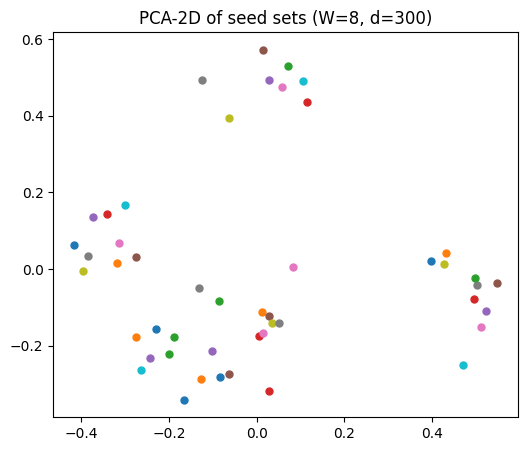

In [51]:
words, ytrue, X = seed_matrix(BEST_E, word2id, SEED_SETS)
pca2 = PCA(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(6,5))
for w, lab, (x,y) in zip(words, ytrue, pca2):
    plt.scatter(x, y, s=25)
plt.title(f"PCA-2D of seed sets (W={best_W}, d={best_d})")
plt.show()



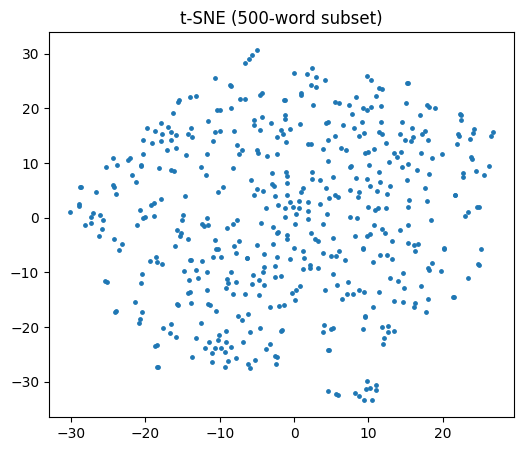

In [52]:
subset_n = min(500, N)
idx = np.arange(N)[:subset_n]
Xsub = BEST_E[idx]
tsne2 = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42).fit_transform(Xsub)

plt.figure(figsize=(6,5))
plt.scatter(tsne2[:,0], tsne2[:,1], s=6)
plt.title("t-SNE (500-word subset)")
plt.show()


In [53]:
# Use the PPMI+SVD embeddings you selected earlier
E_VIS = BEST_E      # <- PPMI+SVD (W=best_W, d=best_d)

# (optional) quick sanity check
print("E_VIS shape:", E_VIS.shape, "| source: PPMI+SVD")


E_VIS shape: (5314, 300) | source: PPMI+SVD


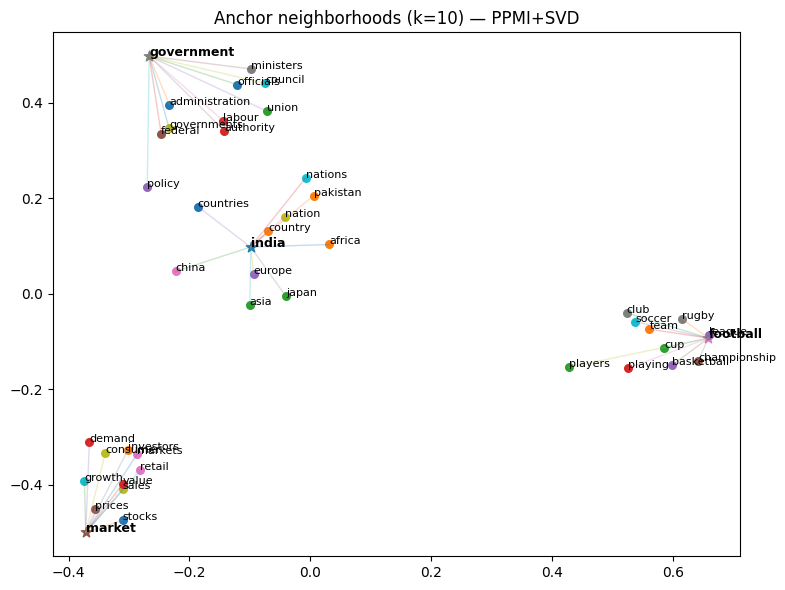

In [54]:
# Visually inspect neighborhoods for your anchors, with labels and edges.
anchors = ["india", "government", "football", "market"]  # edit if you like
k = 10  # neighbors

def top_neighbors_from_emb(E, word, k=10):
    if word not in word2id: return []
    i = word2id[word]
    sims = E @ E[i]
    sims[i] = -1.0
    top = np.argpartition(-sims, range(k))[:k]
    top = top[np.argsort(-sims[top])]
    return [(id2word[j], float(sims[j])) for j in top]

# Collect anchor + neighbors
picked = []
edges = []
for a in anchors:
    if a not in word2id:
        continue
    picked.append(a)
    for w, s in top_neighbors_from_emb(E_VIS, a, k=k):
        picked.append(w)
        edges.append((a, w, s))

picked = sorted(set(picked))
X = np.vstack([E_VIS[word2id[w]] for w in picked])

# Project to 2D (PCA is fine here)
xy = PCA(n_components=2, random_state=42).fit_transform(X)
pos = {w: xy[i] for i, w in enumerate(picked)}

plt.figure(figsize=(8,6))
# draw edges from anchor -> neighbor
for a, w, s in edges:
    x1, y1 = pos[a]; x2, y2 = pos[w]
    plt.plot([x1, x2], [y1, y2], alpha=0.25, linewidth=1)

# draw points + labels (anchors highlighted)
for w in picked:
    x, y = pos[w]
    is_anchor = w in anchors
    plt.scatter(x, y, s=60 if is_anchor else 30,
                marker='*' if is_anchor else 'o')
    plt.text(x, y, w, fontsize=9 if is_anchor else 8,
             fontweight='bold' if is_anchor else 'normal')

plt.title(f"Anchor neighborhoods (k={k}) — {'PPMI+SVD' if E_VIS is BEST_E else 'fastText'}")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3792001687.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(SEED_SETS))


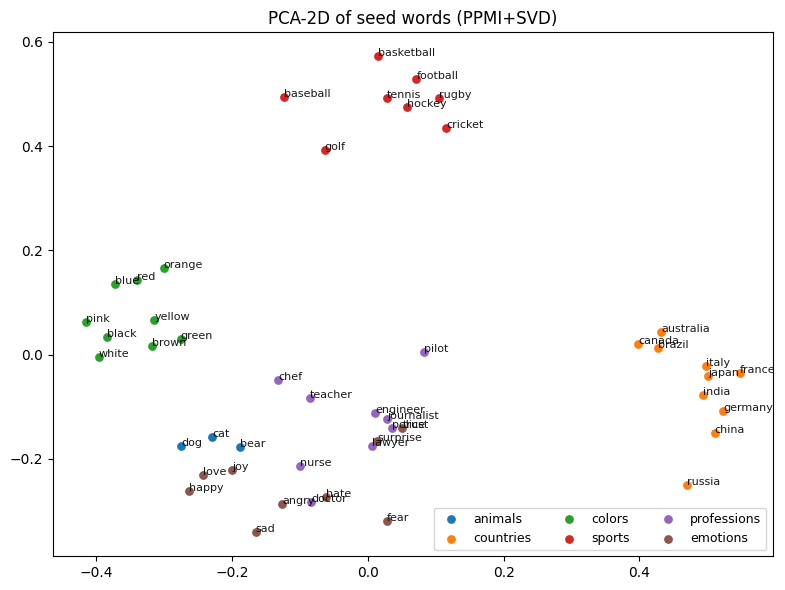

In [55]:
# Choose which embedding to visualize:
E_VIS = BEST_E   # or FT_E for fastText

# Build seed matrix
words, cats, X = seed_matrix(E_VIS, word2id, SEED_SETS)

# 2D PCA
pca2 = PCA(n_components=2, random_state=42).fit_transform(X)

# Plot with labels
plt.figure(figsize=(8,6))
palette = plt.cm.get_cmap('tab10', len(SEED_SETS))
cat_list = list(SEED_SETS.keys())
cat_to_idx = {c:i for i,c in enumerate(cat_list)}

for c in cat_list:
    idx = [i for i, lab in enumerate(cats) if lab == c]
    plt.scatter(pca2[idx,0], pca2[idx,1], s=28, label=c)
    for i in idx:
        plt.text(pca2[i,0], pca2[i,1], words[i], fontsize=8, alpha=0.9)

plt.title(f"PCA-2D of seed words ({'PPMI+SVD' if E_VIS is BEST_E else 'fastText'})")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()


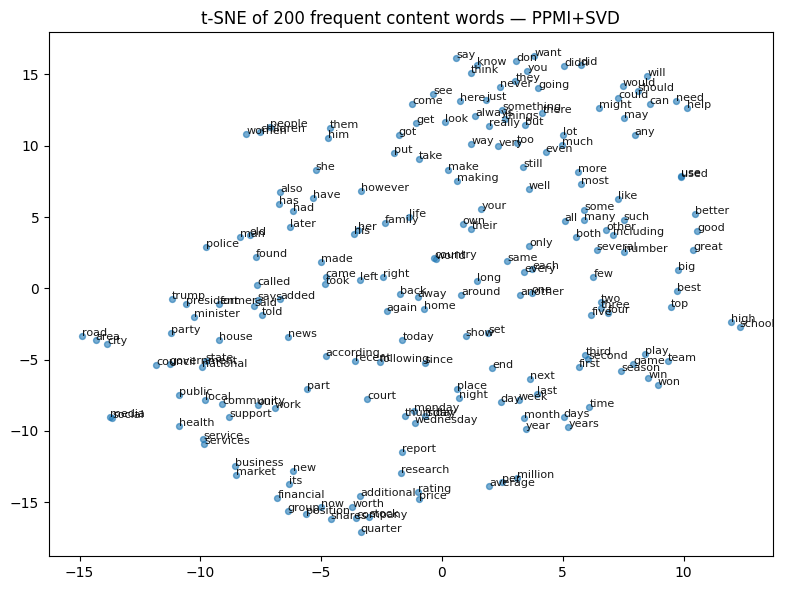

In [56]:
# Take top-N frequent *content* words (no stopwords) so t-SNE is meaningful.
N_LABELLED = 200

def top_content_words(raw_counts, word2id, stopwords, n=200):
    items = [(w, c) for w, c in raw_counts.items()
             if w in word2id and w not in stopwords and len(w) > 2]
    items.sort(key=lambda x: -x[1])
    return [w for w, _ in items[:n]]

words_tsne = top_content_words(raw_counts, word2id, STOPWORDS, n=N_LABELLED)
X = np.vstack([E_VIS[word2id[w]] for w in words_tsne])

tsne2 = TSNE(n_components=2, perplexity=30, learning_rate='auto',
             init='random', random_state=42).fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(tsne2[:,0], tsne2[:,1], s=18, alpha=0.6)
for (x, y), w in zip(tsne2, words_tsne):
    plt.text(x, y, w, fontsize=8, alpha=0.9)
plt.title(f"t-SNE of {N_LABELLED} frequent content words — {'PPMI+SVD' if E_VIS is BEST_E else 'fastText'}")
plt.tight_layout()
plt.show()


In [57]:
FT_ZIP = "wiki-news-300d-1M.vec.zip"
FT_INNER = "wiki-news-300d-1M.vec"
FT_URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

if not os.path.exists(FT_ZIP):
    !wget -q {FT_URL} -O {FT_ZIP}
    print("Downloaded fastText vectors.")
else:
    print("fastText zip already present.")


fastText zip already present.


In [58]:
def embed_from_fasttext_vec_zip(zip_path, inner_name, word2id, dim=300):
    E = np.zeros((len(word2id), dim), dtype=np.float32)
    found = 0
    with zipfile.ZipFile(zip_path) as z:
        with z.open(inner_name) as f:
            _ = f.readline()  # header: "1000000 300"
            for bline in f:
                line = bline.decode('utf-8', errors='ignore').rstrip('\n')
                if not line:
                    continue
                parts = line.split(' ')
                w = parts[0]
                if w in word2id:
                    vec = np.asarray(parts[1:], dtype=np.float32)
                    if vec.size == dim:
                        E[word2id[w]] = vec
                        found += 1
    E = normalize(E)
    print(f"fastText vectors found for {found}/{len(word2id)} vocab words.")
    return E

FT_E = embed_from_fasttext_vec_zip(FT_ZIP, FT_INNER, word2id, dim=300)


fastText vectors found for 5301/5314 vocab words.


In [59]:
ft_purity, ft_nmi = eval_seed_purity(FT_E)
ft_simlex, c1 = eval_similarity(FT_E, word2id, simlex)
ft_ws353,  c2 = eval_similarity(FT_E, word2id, ws353)

print(f"fastText seed purity={ft_purity:.3f}, NMI={ft_nmi:.3f}")
print(f"fastText SimLex-999: ρ={ft_simlex:.3f} (pairs={c1})")
print(f"fastText WordSim-353: ρ={ft_ws353:.3f} (pairs={c2})")


fastText seed purity=0.938, NMI=0.907
fastText SimLex-999: ρ=0.379 (pairs=437)
fastText WordSim-353: ρ=0.740 (pairs=188)


In [60]:
def top_neighbors_from_emb(E, word, k=10):
    if word not in word2id: return []
    i = word2id[word]
    sims = E @ E[i]
    sims[i] = -1.0
    top = np.argpartition(-sims, range(k))[:k]
    top = top[np.argsort(-sims[top])]
    return [(id2word[j], float(sims[j])) for j in top]

for w in ANCHORS:
    print(f"\n== Neighbors by embedding for '{w}' ==")
    print("PPMI+SVD:", top_neighbors_from_emb(BEST_E, w, TOPK_NEIGH))
    print("fastText:", top_neighbors_from_emb(FT_E, w, TOPK_NEIGH))



== Neighbors by embedding for 'india' ==
PPMI+SVD: [('africa', 0.7176001667976379), ('pakistan', 0.7169266939163208), ('china', 0.7122316956520081), ('nations', 0.6849081516265869), ('countries', 0.6807472705841064), ('country', 0.6662631034851074), ('nation', 0.6631017327308655), ('japan', 0.6595419049263), ('europe', 0.6575865745544434), ('asia', 0.6548933982849121)]
fastText: [('pakistan', 0.7778925895690918), ('indian', 0.7542898654937744), ('delhi', 0.6968334913253784), ('asia', 0.6809784173965454), ('usa', 0.6749919056892395), ('america', 0.6686625480651855), ('australia', 0.6674277782440186), ('russia', 0.6565300226211548), ('bangladesh', 0.6520073413848877), ('kashmir', 0.6359738111495972)]

== Neighbors by embedding for 'government' ==
PPMI+SVD: [('governments', 0.7510100603103638), ('administration', 0.7199239730834961), ('officials', 0.6999514102935791), ('federal', 0.69818115234375), ('union', 0.6711527109146118), ('ministers', 0.6612629890441895), ('labour', 0.66105663776

In [61]:
def analogy_score(E, a, b, c, target):
    for w in (a,b,c,target):
        if w not in word2id: return 0
    va, vb, vc = E[word2id[a]], E[word2id[b]], E[word2id[c]]
    q = vb - va + vc
    sims = E @ q
    for w in (a,b,c):
        sims[word2id[w]] = -1.0
    pred = np.argmax(sims)
    return 1 if id2word[pred] == target else 0

tests = [
    ("paris","france","berlin","germany"),
    ("tokyo","japan","madrid","spain"),
    ("king","man","queen","woman"),
    ("run","running","walk","walking"),
]

def run_analogies(E, tests):
    ok = 0
    for a,b,c,t in tests:
        ok += analogy_score(E, a,b,c,t)
    return ok, len(tests)

ok_ppmi, tot = run_analogies(BEST_E, tests)
ok_ft,   _   = run_analogies(FT_E, tests)
print(f"Analogies PPMI+SVD: {ok_ppmi}/{tot} | fastText: {ok_ft}/{tot}")


Analogies PPMI+SVD: 2/4 | fastText: 3/4


/tmp/ipython-input-926028715.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(SEED_SETS))


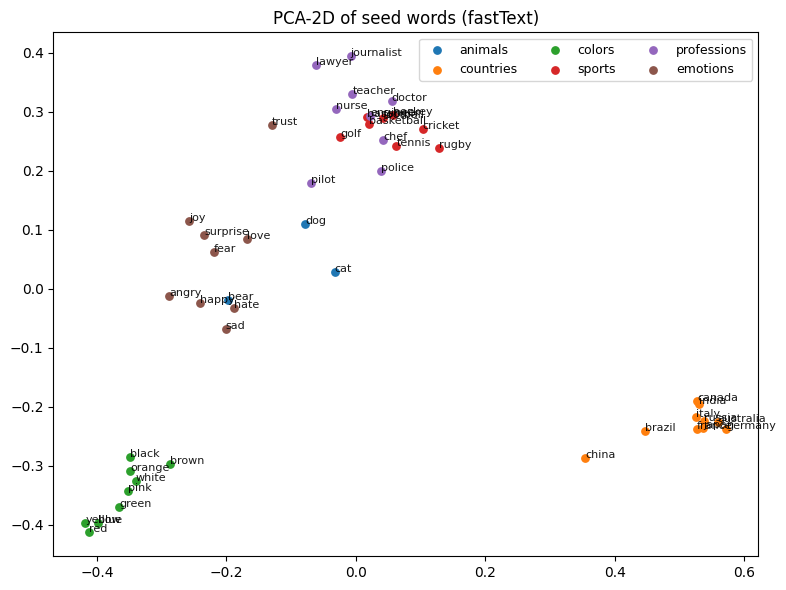

In [62]:
# Choose which embedding to visualize:
E_VIS = FT_E   # or FT_E for fastText

# Build seed matrix
words, cats, X = seed_matrix(E_VIS, word2id, SEED_SETS)

# 2D PCA
pca2 = PCA(n_components=2, random_state=42).fit_transform(X)

# Plot with labels
plt.figure(figsize=(8,6))
palette = plt.cm.get_cmap('tab10', len(SEED_SETS))
cat_list = list(SEED_SETS.keys())
cat_to_idx = {c:i for i,c in enumerate(cat_list)}

for c in cat_list:
    idx = [i for i, lab in enumerate(cats) if lab == c]
    plt.scatter(pca2[idx,0], pca2[idx,1], s=28, label=c)
    for i in idx:
        plt.text(pca2[i,0], pca2[i,1], words[i], fontsize=8, alpha=0.9)

plt.title(f"PCA-2D of seed words ({'PPMI+SVD' if E_VIS is BEST_E else 'fastText'})")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()


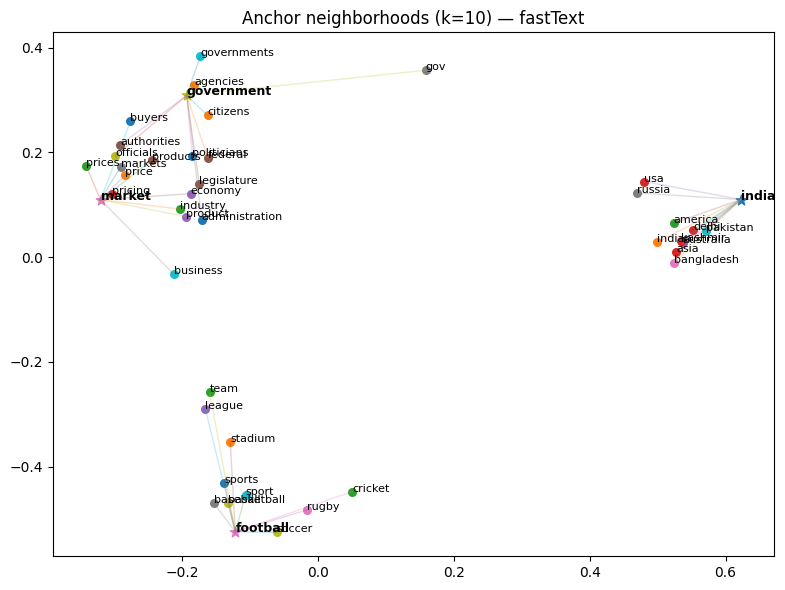

In [63]:
# Visually inspect neighborhoods for your anchors, with labels and edges.
anchors = ["india", "government", "football", "market"]  # edit if you like
k = 10  # neighbors

def top_neighbors_from_emb(E, word, k=10):
    if word not in word2id: return []
    i = word2id[word]
    sims = E @ E[i]
    sims[i] = -1.0
    top = np.argpartition(-sims, range(k))[:k]
    top = top[np.argsort(-sims[top])]
    return [(id2word[j], float(sims[j])) for j in top]

# Collect anchor + neighbors
picked = []
edges = []
for a in anchors:
    if a not in word2id:
        continue
    picked.append(a)
    for w, s in top_neighbors_from_emb(E_VIS, a, k=k):
        picked.append(w)
        edges.append((a, w, s))

picked = sorted(set(picked))
X = np.vstack([E_VIS[word2id[w]] for w in picked])

# Project to 2D (PCA is fine here)
xy = PCA(n_components=2, random_state=42).fit_transform(X)
pos = {w: xy[i] for i, w in enumerate(picked)}

plt.figure(figsize=(8,6))
# draw edges from anchor -> neighbor
for a, w, s in edges:
    x1, y1 = pos[a]; x2, y2 = pos[w]
    plt.plot([x1, x2], [y1, y2], alpha=0.25, linewidth=1)

# draw points + labels (anchors highlighted)
for w in picked:
    x, y = pos[w]
    is_anchor = w in anchors
    plt.scatter(x, y, s=60 if is_anchor else 30,
                marker='*' if is_anchor else 'o')
    plt.text(x, y, w, fontsize=9 if is_anchor else 8,
             fontweight='bold' if is_anchor else 'normal')

plt.title(f"Anchor neighborhoods (k={k}) — {'PPMI+SVD' if E_VIS is BEST_E else 'fastText'}")
plt.tight_layout()
plt.show()


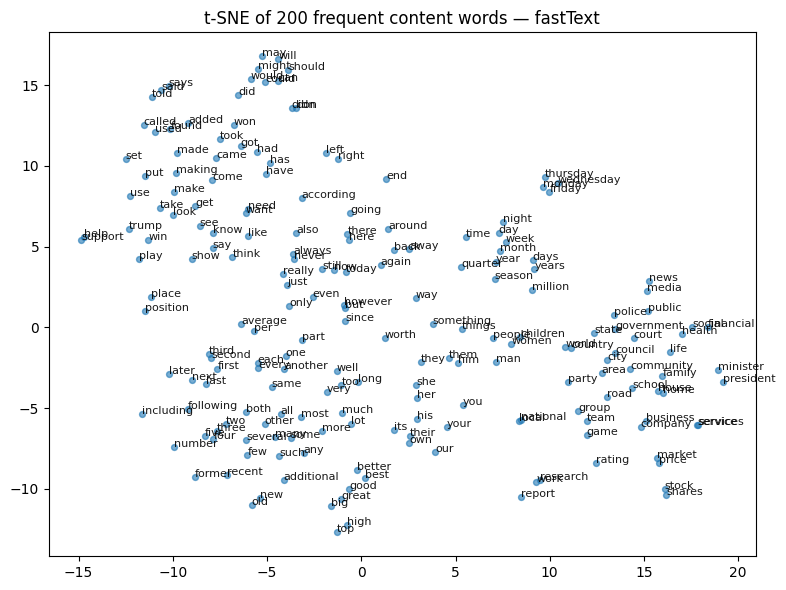

In [64]:
# Take top-N frequent *content* words (no stopwords) so t-SNE is meaningful.
N_LABELLED = 200

def top_content_words(raw_counts, word2id, stopwords, n=200):
    items = [(w, c) for w, c in raw_counts.items()
             if w in word2id and w not in stopwords and len(w) > 2]
    items.sort(key=lambda x: -x[1])
    return [w for w, _ in items[:n]]

words_tsne = top_content_words(raw_counts, word2id, STOPWORDS, n=N_LABELLED)
X = np.vstack([E_VIS[word2id[w]] for w in words_tsne])

tsne2 = TSNE(n_components=2, perplexity=30, learning_rate='auto',
             init='random', random_state=42).fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(tsne2[:,0], tsne2[:,1], s=18, alpha=0.6)
for (x, y), w in zip(tsne2, words_tsne):
    plt.text(x, y, w, fontsize=8, alpha=0.9)
plt.title(f"t-SNE of {N_LABELLED} frequent content words — {'PPMI+SVD' if E_VIS is BEST_E else 'fastText'}")
plt.tight_layout()
plt.show()
